NI (Note d'Irène) : J'ai construit ma solution autour de celle qui était fournie par l'organisation dans le tutoriel Python. La plupart des commentaires ici sont donc ceux des organisateurs. Pour la lisibilité, j'ai signalé mes commentaires et mes changements au code par l'entête NI.

NI : La chronologie des changements apportés n'est pas respectée, car tout a été fait en vrac, vu les contraintes de temps ! :)

# Tutoriel Python

Ce tutoriel a pour but de guider les personnes souhaitant utiliser Python pour participer au challenge.

Il comporte cinq etapes :

* Import des donnees
* Analyse descriptive
* Preparation des donnees
* Creation d’un modele en cross validation
* Calcul des predictions et soumission

# Import des données

Avant de rentrer dans le vif du sujet, importons quelques packages necessaires pour ce tutoriel :

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# Librairie de visualisation super cool
import seaborn as sns # pip install seaborn

Les datasets sont sous format .csv. Vous pouvez les importer avec le code ci-dessous.

In [3]:
train = pd.read_csv('data_challenge/boites_medicaments_train.csv',
                    encoding='utf-8',
                    sep=';')

test = pd.read_csv('data_challenge/boites_medicaments_test.csv',
                   encoding='utf-8', 
                   sep=';')

In [4]:
pd.set_option("display.max_columns", 99) # permet de voir toutes les colonnes
train.head(10)

,libelle,libelle_plaquette,libelle_ampoule,libelle_flacon,libelle_tube,libelle_stylo,libelle_seringue,libelle_pilulier,libelle_sachet,libelle_comprime,libelle_gelule,libelle_film,libelle_poche,libelle_capsule,nb_plaquette,nb_ampoule,nb_flacon,nb_tube,nb_stylo,nb_seringue,nb_pilulier,nb_sachet,nb_comprime,nb_gelule,nb_film,nb_poche,nb_capsule,nb_ml,statut,etat commerc,agrement col,tx rembours,forme pharma,voies admin,statut admin,date declar annee,date amm annee,type proc,titulaires,substances,prix
0,3 plaquette(s) thermoformée(s) PVC-Aluminium d...,1,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,28,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé pelliculé,orale,Autorisation active,2014,2014,Procédure décentralisée,MAJORELLE LUXEMBOURG SOPARFI (LUXEMBOURG),DÉSOGESTREL,2.83
1,plaquette(s) thermoformée(s) aluminium de 28 c...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé à croquer,orale,Autorisation active,2013,2009,Procédure de reconnaissance mutuelle,TEVA SANTE,"MONTÉLUKAST ACIDE, MONTÉLUKAST SODIQUE",14.30
2,plaquette(s) thermoformée(s) PVC-aluminium de ...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,gélule à libération prolongée,orale,Autorisation active,2000,1996,Procédure nationale,MYLAN SAS,CHLORHYDRATE DE DILTIAZEM,5.66
3,30 sachet(s)-dose(s) papier aluminium complexe...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,granulés à libération prolongée,orale,Autorisation active,2005,2004,Procédure nationale,SANOFI AVENTIS FRANCE,"ACIDE VALPROÏQUE, VALPROATE DE SODIUM",24.27
4,plaquette(s) thermoformée(s) PVC-Aluminium de ...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0.0,Présentation active,Déclaration d'arrêt de commercialisation,non,100%,comprimé pelliculé,orale,Autorisation active,2015,2010,Procédure nationale,TEVA SANTE,LÉTROZOLE,59.94
5,plaquette(s) thermoformée(s) PVC-aluminium de ...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,100%,comprimé,orale,Autorisation active,2001,2000,Procédure nationale,EG LABO - LABORATOIRES EUROGENERICS,FLUTAMIDE,27.17
6,flacon(s) polyéthylène haute densité (PEHD) de...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,100,0.0,Présentation active,Déclaration de commercialisation,oui,100%,capsule molle,orale,Autorisation active,2015,2001,Procédure centralisée,EISAI (ROYAUME-UNI),BEXAROTÈNE,877.83
7,plaquette(s) thermoformée(s) PVC polyéthylène ...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé,orale,Autorisation active,2006,2006,Procédure de reconnaissance mutuelle,SANDOZ,GLIMÉPIRIDE,6.58
8,plaquette(s) thermoformée(s) PVC-Aluminium de ...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,90,0,0,0,0,0.0,Présentation active,Déclaration d'arrêt de commercialisation,oui,65%,comprimé sécable,orale,Autorisation active,2013,2002,Procédure nationale,ARROW GENERIQUES,MALÉATE D'ÉNALAPRIL,18.63
9,plaquette(s) polyamide aluminium PVC de 10 com...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,non,65%,comprimé pelliculé,orale,Autorisation active,2015,2012,Procédure nationale,ARROW GENERIQUES,"CEFPODOXIME PROXÉTIL, CEFPODOXIME",6.13


On est maintenant pret a attaquer les choses serieuses ! :)

# Analyse descriptive

### Structure des datasets

Le dataset ```train``` comporte les caracteristiques et prix de 8564 boites de medicaments. C'est ce dataset que nous allons utiliser pour creer un modele.
Chaque boite de medicament est decrite par une observation de 41 variables. Ces variables sont decrites dans le fichier `Description.pdf` present dans la cle usb.

Le dataset ```test``` comporte les caracteristiques des 3671 boites de medicaments dont il faut predire le prix. A la difference de ```train```, le prix des boites de medicaments n'est bien sur pas inclus et une colonne `id` a ete ajoutée pour identifier les boites de medicaments pendant l'etape de soumission des predictions sur [Datascience.net](www.datascience.net)

### Distribution des donnees

Jetons maintenant un coup d'oeil a la distribution des donnees

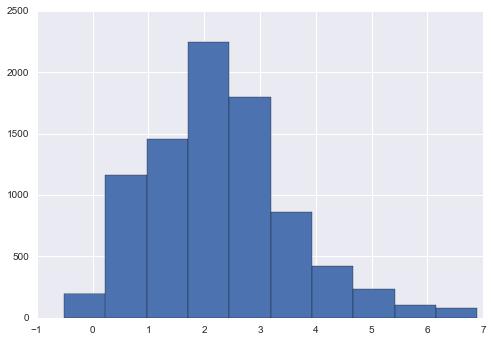

In [5]:
# Distribution du log des prix
# On prend le log des prix car sa distribution est plus proche d'une gaussienne
train['logprix'] = train['prix'].apply(np.log)
train['logprix'].hist()

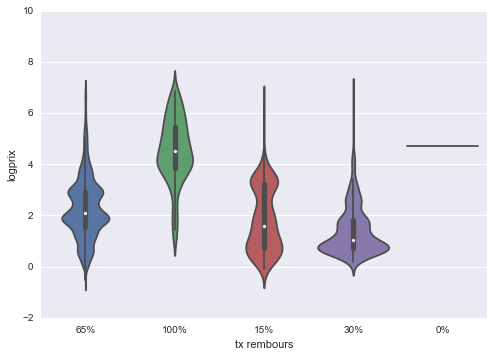

In [6]:
# Influence sur les prix de la feature "tx rembours"
sns.violinplot(y="logprix", x="tx rembours", data=train)

NI : Pour la variable "voies admin", qui contient les différents modes d'administration, on sépare le texte suivant les virgules et on gére les différents modes comme autant de variables on/off.

In [7]:
# NI
temp = train['voies admin'].apply(lambda st : st.split(','))
admins = set([l for j in temp for l in j])
for voie in admins:
    train[voie] = train['voies admin'].apply(lambda x : 1 if voie in x else 0)
    test[voie] = test['voies admin'].apply(lambda x : 1 if voie in x else 0)

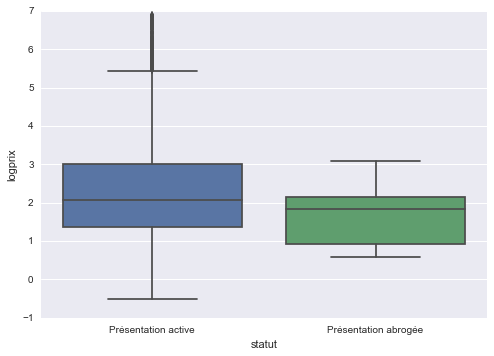

In [8]:
# Influence sur les prix de la feature "statut"
sns.boxplot(y="logprix", x="statut", data=train)

NI : On va supposer que le laboratoire qui a le médoc a une influence sur le prix, ainsi que les substances que contient le médicament.

In [9]:
# NI
temp = train['titulaires'].apply(lambda st : st.split(','))
labos = set([l for j in temp for l in j])
for lab in labos:
    train[lab] = train['titulaires'].apply(lambda x : 1 if lab in x else 0)
    test[lab] = test['titulaires'].apply(lambda x : 1 if lab in x else 0)

In [10]:
# NI
temp = train['substances'].apply(lambda st : st.split(','))
train['nb_sub'] = train['substances'].apply(lambda st : len(st.split(',')))
test['nb_sub'] = test['substances'].apply(lambda st : len(st.split(',')))
subs = set([l for j in temp for l in j])
for s in subs:
    train[s] = train['substances'].apply(lambda x : 1 if s in x else 0)
    test[s] = test['substances'].apply(lambda x : 1 if s in x else 0)

# Preparation des donnees

### Types de features

In [11]:
# NI : quelques changements ici.
# features numériques
feat_num = ['libelle_plaquette', 'libelle_ampoule', 'libelle_flacon', 
            'libelle_tube', 'libelle_stylo', 'libelle_seringue',
            'libelle_pilulier', 'libelle_sachet', 'libelle_comprime', 
            'libelle_gelule', 'libelle_film', 'libelle_poche',
            'libelle_capsule'] + ['nb_plaquette', 'nb_ampoule', 
            'nb_flacon', 'nb_tube', 'nb_stylo', 'nb_seringue',
            'nb_pilulier', 'nb_sachet', 'nb_comprime', 'nb_gelule', 
            'nb_film', 'nb_poche', 'nb_capsule', 'nb_ml']
# features date
feat_dates = ['date declar annee', 'date amm annee']
# features catégorielles
#feat_cat = ['statut', 'etat commerc', 'agrement col', 'tx rembours',
#          'voies admin', 'statut admin', 'type proc'] 
feat_cat = ['statut', 'etat commerc', 'agrement col', 'tx rembours',
          'statut admin', 'type proc', 'forme pharma']  
# NI : voies admin est maintenant traité séparement, ainsi que les labos et les substances
feat_admin = list(admins)
feat_lab = list(labos) # titulaires
feat_sub = list(subs)+['nb_sub'] # substances
# features texte
feat_text = ['libelle', 'titulaires', 'substances']

### Encodage des features catégorielles

Les algorithmes de machine learning s'attendent à avoir en entrée des nombres, et non pas des chaînes de caractères. C'est pourquoi nous transformons les features catégorielles en nombres, à l'aide de LabelEncoder()

In [12]:
for c in feat_cat:
    le = LabelEncoder()
    le.fit(train[c].append(test[c]))
    train[c] = le.transform(train[c])
    test[c] = le.transform(test[c])

# Creation d'un modele

Il est maintenant temps de creer un modele. Dans ce tutoriel nous allons construire une [Foret Aleatoire](https://fr.wikipedia.org/wiki/For%C3%AAt_d'arbres_d%C3%A9cisionnels)

Pour ce faire nous utilisons toutes les variables dont nous disposons, sauf les variables de type "texte".

Pour eviter le [surapprentissage](https://fr.wikipedia.org/wiki/Surapprentissage) et estimer les vraies performances de notre modele nous allons utiliser le critère de [validation croisee](https://fr.wikipedia.org/wiki/Validation_crois%C3%A9e) (cross-validation) methode k-fold.

### Métrique MAPE

La métrique MAPE n'étant pas disponible dans scikit-learn, nous la codons

In [13]:
# Mean Absolute Percentage Error
def mape_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Cross validation

In [14]:
# NI : j'ai transformé en fonction ce qui était fourni par French Data, 
# afin de pouvoir tester facilement les paramétres du RandomForest
def error(ntree):
    err = 0
    NBROUND = 5
    # NI : j'ai augmenté le nombre de variables qui sont utilisés dans le modèle.
    FEATURES = feat_num+feat_cat+feat_dates+feat_lab+feat_admin+feat_sub 
    # on n'utilise que ces features pour ce modèle basique
    for train_index, test_index in KFold(train.shape[0], n_folds=NBROUND):
        y = train['logprix']
        X = train[FEATURES]
        X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        clf = RandomForestRegressor(n_estimators = ntree) # NI : on augmente le nombre d'arbres
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        # ne pas oublier de reprendre l'exponentielle de la prédiction
        err += mape_error(np.exp(y_test), np.exp(pred))
        #print(mape_error(np.exp(y_test), np.exp(pred)))
    print("*** MAPE Error for "+str(ntree)+": ", err / NBROUND)
    return err/NBROUND

In [15]:
# NI : ce code ci est un peu long et je ne l'ai fait tourner qu'une fois au début.
# Le résultat (avec peu de variables en entrée, mais qui se confirme maintenant) 
# m'a poussé à choisir 200 arbres pour la suite 
# (compromis temps-performance, particulièrement important ici !). 
trees = [10,20,50,100,200,500]
for t in trees:
    error(t)

*** MAPE Error for 10:  39.21823298101759
*** MAPE Error for 20:  38.42763526402021
*** MAPE Error for 50:  37.598814501728256
*** MAPE Error for 100:  37.303075311187015
*** MAPE Error for 200:  37.14774944312977
*** MAPE Error for 500:  37.03220829469637


Cela veut dire notre modele predit les prix des medicaments avec environ 65% d’erreur en moyenne. Par exemple, si un medicament vaut reellement 10€, notre prediction sera de 16.5€ (ou 3.5€).

# Calcul des predictions et soumission

In [16]:
clf = RandomForestRegressor(n_estimators = 200)
# On entraine de nouveau le modèle, cette fois sur l'intégralité des données
FEATURES = feat_num+feat_cat+feat_dates+feat_lab+feat_admin+feat_sub
clf.fit(train[FEATURES], train['logprix'])
predictions_training = np.exp(clf.predict(train[FEATURES]))
predictions = np.exp(clf.predict(test[FEATURES]))

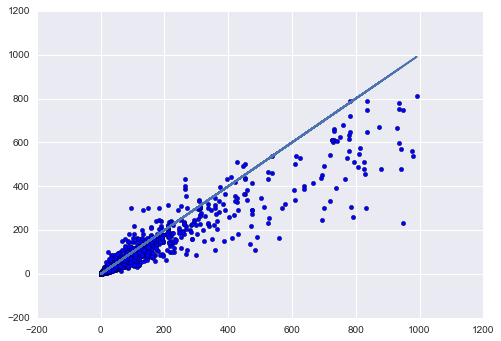

In [17]:
# NI : un petit plot pour le plaisir...
plt.scatter(train['prix'], predictions_training)
plt.plot(train['prix'],train['prix'])

In [18]:
pd.DataFrame(predictions, index=test['id']).to_csv('soumission.csv',  
                          header=['prix'],
                          sep = ';')

Vous etes maintenant pret ? Faites votre premiere soumission en uplodant le fichier `soumission.csv` sur [Datascience.net](www.datascience.net)